<a href="https://colab.research.google.com/github/mariiacamila31/TSLA/blob/main/CAPSTONE_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluating Volatility to Develop Machine Learning Models for stock and call option pricing**
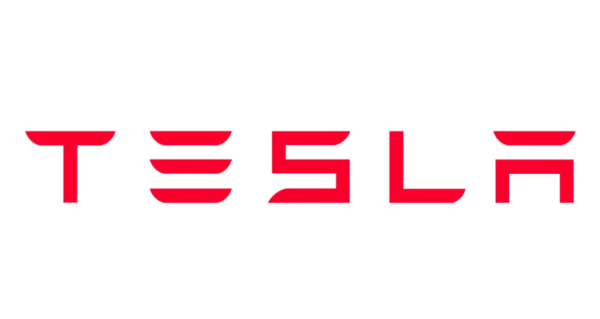

#1. Load the necessary libraries

In [ ]:
# Load the libraries
import math
import pandas as pd
import numpy as np
!pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
!pip install matplotlib mplcursors
import mplcursors
!pip install plotly
import plotly.graph_objects as go
!pip install seaborn
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
!pip install scipy pandas
from scipy.stats import norm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, confusion_matrix, r2_score

# 2. Download the data from Yahoo Finance

Disclaimer: All the data for the analysis is in USD and all the option contracts are regular (100 options per contract)

* Tesla has never paid dividends to investors, the dividend yield is 0 and it will not be used for any of the formulas in the models.


In [ ]:
#Define the ticker symbol
ticker = "TSLA"

# Get TESLA'S stock historical information
data = yf.download(ticker)

# Remove the date from the index
data = data.reset_index()

# Display the data
data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...,...
3543,2024-07-29,224.899994,234.270004,224.699997,232.100006,232.100006,129201800
3544,2024-07-30,232.250000,232.410004,220.000000,222.619995,222.619995,100560300
3545,2024-07-31,227.899994,234.679993,226.789993,232.070007,232.070007,67497000
3546,2024-08-01,227.690002,231.869995,214.330002,216.860001,216.860001,83861900


In [ ]:
# See the data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3548 non-null   datetime64[ns]
 1   Open       3548 non-null   float64       
 2   High       3548 non-null   float64       
 3   Low        3548 non-null   float64       
 4   Close      3548 non-null   float64       
 5   Adj Close  3548 non-null   float64       
 6   Volume     3548 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 194.2 KB


In [ ]:
# Create a Ticker object
ticker = yf.Ticker("TSLA")

# Get the expiration dates for the call and put options
expirations = ticker.options
print(f"Expiration dates: {expirations}")

# Choose an expiration date
if expirations:
  expiration_date = expirations[0] #Select the first expiration date

  # Get the option chain for the selected expiration date
  option_chain = ticker.option_chain(expiration_date)

  # Access the calls and puts data
  calls = option_chain.calls
  puts = option_chain.puts

  print("Calls:")
  print(calls.head(3))

else:
  print("No expiration dates available for this ticker.")

Expiration dates: ('2024-08-02', '2024-08-09', '2024-08-16', '2024-08-23', '2024-08-30', '2024-09-06', '2024-09-20', '2024-10-18', '2024-11-15', '2024-12-20', '2025-01-17', '2025-02-21', '2025-03-21', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18')
Calls:
        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  TSLA240802C00075000 2024-07-26 13:39:21+00:00    75.0     137.43  131.05   
1  TSLA240802C00080000 2024-08-02 17:43:59+00:00    80.0     126.50  127.00   
2  TSLA240802C00085000 2024-08-02 16:28:56+00:00    85.0     121.50  122.00   

     ask     change  percentChange  volume  openInterest  impliedVolatility  \
0  134.3  -6.540008      -4.542619      10            25           5.875003   
1  129.3   3.860001       3.147424      31             2           9.023442   
2  124.3 -52.970000     -30.360520      30             4           8.492192   

   inTheMoney contractSize currency  
0        True      REGULAR      USD 

In [ ]:
#See the call options dataframe
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,TSLA240802C00075000,2024-07-26 13:39:21+00:00,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,True,REGULAR,USD
1,TSLA240802C00080000,2024-08-02 17:43:59+00:00,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,True,REGULAR,USD
2,TSLA240802C00085000,2024-08-02 16:28:56+00:00,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,True,REGULAR,USD
3,TSLA240802C00090000,2024-07-26 13:39:21+00:00,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,True,REGULAR,USD
4,TSLA240802C00095000,2024-08-01 13:36:52+00:00,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,TSLA240802C00410000,2024-07-29 13:57:23+00:00,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,False,REGULAR,USD
84,TSLA240802C00420000,2024-07-25 14:06:43+00:00,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,False,REGULAR,USD
85,TSLA240802C00430000,2024-07-29 16:28:58+00:00,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,False,REGULAR,USD
86,TSLA240802C00440000,2024-07-23 19:46:37+00:00,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,False,REGULAR,USD


#3. Data Preprocessing

In [ ]:
# Define a function to extract the option's expiration date from the Contract Symbol
def extract_expiration_date(contract_symbol):
  year = "20" + contract_symbol[4:6]
  month = contract_symbol[6:8]
  day = contract_symbol[8:10]
  return f"{year}-{month}-{day}"

In [ ]:
# Apply same the function to the data frame and create a column for the call option expiration dates
calls["expirationDate"] = calls["contractSymbol"].apply(extract_expiration_date)

# Replace the values of the "inTheMoney" column from True -> 1 and from False -> 0
calls["inTheMoney"] = calls["inTheMoney"].astype(int)

# Convert "lastTradeDate" and "expirationDate" to datetime
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate'])
calls['expirationDate'] = pd.to_datetime(calls['expirationDate'])

# Drop the "contractSymbol" column
calls = calls.drop(columns=["contractSymbol"])

# Drop the "currency" column
calls = calls.drop(columns=["currency"])

# Drop the "contractSize" column
calls = calls.drop(columns=["contractSize"])

# See the new data attributes
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   lastTradeDate      88 non-null     datetime64[ns, UTC]
 1   strike             88 non-null     float64            
 2   lastPrice          88 non-null     float64            
 3   bid                88 non-null     float64            
 4   ask                88 non-null     float64            
 5   change             88 non-null     float64            
 6   percentChange      88 non-null     float64            
 7   volume             88 non-null     int64              
 8   openInterest       88 non-null     int64              
 9   impliedVolatility  88 non-null     float64            
 10  inTheMoney         88 non-null     int64              
 11  expirationDate     88 non-null     datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float6

In [ ]:
# See the new dataframe
calls

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate
0,2024-07-26 13:39:21+00:00,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02
1,2024-08-02 17:43:59+00:00,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,1,2024-08-02
2,2024-08-02 16:28:56+00:00,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02
3,2024-07-26 13:39:21+00:00,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02
4,2024-08-01 13:36:52+00:00,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02
...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-07-29 13:57:23+00:00,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,0,2024-08-02
84,2024-07-25 14:06:43+00:00,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,0,2024-08-02
85,2024-07-29 16:28:58+00:00,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,0,2024-08-02
86,2024-07-23 19:46:37+00:00,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,0,2024-08-02


In [ ]:
# Extract the date and format it as 'YYYY-MM-DD'
calls['lastTradeDate'] = calls['lastTradeDate'].dt.strftime('%Y-%m-%d')

# Convert the lastTradeDate column to datetime
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate'])

# See the results
calls

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate
0,2024-07-26,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02
1,2024-08-02,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,1,2024-08-02
2,2024-08-02,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02
3,2024-07-26,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02
4,2024-08-01,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02
...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-07-29,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,0,2024-08-02
84,2024-07-25,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,0,2024-08-02
85,2024-07-29,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,0,2024-08-02
86,2024-07-23,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,0,2024-08-02


In [ ]:
#See the final data types
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   lastTradeDate      88 non-null     datetime64[ns]
 1   strike             88 non-null     float64       
 2   lastPrice          88 non-null     float64       
 3   bid                88 non-null     float64       
 4   ask                88 non-null     float64       
 5   change             88 non-null     float64       
 6   percentChange      88 non-null     float64       
 7   volume             88 non-null     int64         
 8   openInterest       88 non-null     int64         
 9   impliedVolatility  88 non-null     float64       
 10  inTheMoney         88 non-null     int64         
 11  expirationDate     88 non-null     datetime64[ns]
dtypes: datetime64[ns](2), float64(7), int64(3)
memory usage: 8.4 KB


# 4. Exploratory Data Analysis (EDA)


Calculate the descriptive statistics

In [ ]:
# Print the descriptive statistics for the TSLA
data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,3548,3548.000000,3548.000000,3548.000000,3548.000000,3548.000000,3.548000e+03
mean,2017-07-14 21:33:53.370913280,75.630773,77.286408,73.863466,75.608498,75.608498,9.698056e+07
min,2010-06-29 00:00:00,1.076000,1.108667,0.998667,1.053333,1.053333,1.777500e+06
25%,2014-01-06 18:00:00,11.533667,11.910833,11.258167,11.612334,11.612334,4.770712e+07
50%,2017-07-15 12:00:00,17.467000,17.696667,17.123667,17.462333,17.462333,8.247975e+07
75%,2021-01-22 18:00:00,162.742504,165.737495,158.770000,162.150837,162.150837,1.228170e+08
max,2024-08-02 00:00:00,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08
std,NaN,102.577503,104.853648,100.094805,102.498477,102.498477,7.863733e+07


In [ ]:
# Print the descriptive statistics for the call options
calls.describe()

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate
count,88,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88
mean,2024-08-01 04:05:27.272727296,247.471591,21.263864,20.854545,21.647045,-4.669204,-31.665097,6413.977273,4547.579545,2.560550,0.352273,2024-08-02 00:00:00
min,2024-07-23 00:00:00,75.000000,0.010000,0.000000,0.010000,-52.970000,-99.871796,1.000000,2.000000,0.099130,0.000000,2024-08-02 00:00:00
25%,2024-08-02 00:00:00,183.750000,0.010000,0.000000,0.010000,-9.442500,-58.137252,11.750000,230.500000,1.109379,0.000000,2024-08-02 00:00:00
50%,2024-08-02 00:00:00,241.250000,0.010000,0.000000,0.010000,-0.035000,-17.854678,98.000000,1189.000000,2.218754,0.000000,2024-08-02 00:00:00
75%,2024-08-02 00:00:00,316.250000,23.537500,23.450000,25.550000,0.000000,0.000000,998.000000,6691.750000,3.491212,1.000000,2024-08-02 00:00:00
max,2024-08-02 00:00:00,450.000000,137.430000,131.050000,134.300000,3.860001,3.147424,102847.000000,44406.000000,9.023442,1.000000,2024-08-02 00:00:00
std,NaN,95.108449,38.541023,37.661279,38.617506,8.053391,35.736310,17896.510656,7054.479718,1.925845,0.480416,NaN


Find the correlations between the variables in the dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3548 entries, 0 to 3547
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3548 non-null   datetime64[ns]
 1   Open       3548 non-null   float64       
 2   High       3548 non-null   float64       
 3   Low        3548 non-null   float64       
 4   Close      3548 non-null   float64       
 5   Adj Close  3548 non-null   float64       
 6   Volume     3548 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 194.2 KB


In [ ]:
#Calculate the correlation matrix for TSLA
corr_tsla = data.corr()

#Display the correlation matrix
corr_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.000000,0.784484,0.784456,0.785030,0.784779,0.784779,0.376295
Open,0.784484,1.000000,0.999725,0.999626,0.999218,0.999218,0.105146
High,0.784456,0.999725,1.000000,0.999632,0.999649,0.999649,0.108777
Low,0.785030,0.999626,0.999632,1.000000,0.999688,0.999688,0.101893
Close,0.784779,0.999218,0.999649,0.999688,1.000000,1.000000,0.106109
Adj Close,0.784779,0.999218,0.999649,0.999688,1.000000,1.000000,0.106109
Volume,0.376295,0.105146,0.108777,0.101893,0.106109,0.106109,1.000000


We can conclude that the volume has little to no impact on the rest of the data's behavior

In [ ]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   lastTradeDate      88 non-null     datetime64[ns]
 1   strike             88 non-null     float64       
 2   lastPrice          88 non-null     float64       
 3   bid                88 non-null     float64       
 4   ask                88 non-null     float64       
 5   change             88 non-null     float64       
 6   percentChange      88 non-null     float64       
 7   volume             88 non-null     int64         
 8   openInterest       88 non-null     int64         
 9   impliedVolatility  88 non-null     float64       
 10  inTheMoney         88 non-null     int64         
 11  expirationDate     88 non-null     datetime64[ns]
dtypes: datetime64[ns](2), float64(7), int64(3)
memory usage: 8.4 KB


In [ ]:
# Calculate the correlation matrix for the call options
corr_calls = calls.corr()

# Display the correlation matrix
corr_calls

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate
lastTradeDate,1.000000,-0.343841,-0.051834,-0.045363,-0.042052,-0.149664,-0.327004,0.135712,0.200136,-0.347192,0.116905,NaN
strike,-0.343841,1.000000,-0.756767,-0.758417,-0.762642,0.631153,0.280422,-0.111012,0.081752,-0.193145,-0.777733,NaN
lastPrice,-0.051834,-0.756767,1.000000,0.999614,0.999473,-0.636379,0.261938,-0.196773,-0.351649,0.757996,0.752024,NaN
bid,-0.045363,-0.758417,0.999614,1.000000,0.999850,-0.644962,0.261519,-0.197568,-0.353090,0.759717,0.755169,NaN
ask,-0.042052,-0.762642,0.999473,0.999850,1.000000,-0.649446,0.260422,-0.199486,-0.356722,0.753908,0.764091,NaN
change,-0.149664,0.631153,-0.636379,-0.644962,-0.649446,1.000000,0.008501,0.019034,0.338878,-0.369449,-0.718669,NaN
percentChange,-0.327004,0.280422,0.261938,0.261519,0.260422,0.008501,1.000000,-0.643650,-0.463648,0.639832,0.097334,NaN
volume,0.135712,-0.111012,-0.196773,-0.197568,-0.199486,0.019034,-0.643650,1.000000,0.222452,-0.407824,-0.177391,NaN
openInterest,0.200136,0.081752,-0.351649,-0.353090,-0.356722,0.338878,-0.463648,0.222452,1.000000,-0.414044,-0.443126,NaN
impliedVolatility,-0.347192,-0.193145,0.757996,0.759717,0.753908,-0.369449,0.639832,-0.407824,-0.414044,1.000000,0.363010,NaN


#5. Stock Movement and Returns




In [ ]:
# Create a visualization of the price movements for TSLA

# Define the variable relevant data
relevant_data = data[["Date", "Adj Close"]]

# Define the variables
x = relevant_data["Date"]
y = relevant_data["Adj Close"] #Use the adj closing price to reflect any dividends paid

# Create the figure
fig = go.Figure()

# Add the features
fig.add_trace(go.Scatter(x=x, y=y, mode="lines", name="line_name", line=dict(color="blue")))

# Add the title and labels
fig.update_layout(title="Tesla (TSLA) Price Fluctuations",
                  xaxis_title = "Date",
                  yaxis_title = "Price")
# Show the graph
fig.show();

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



1. Calculate the returns for TSLA

In [ ]:
# Ensure the Date column is the index
relevant_data.reset_index(inplace=True)

# Calculate the returns of the adjusted price
relevant_data["Returns (%)"] = ((relevant_data["Adj Close"].pct_change()) * 100).round(2)  # Percentage change

# Drop the NaN values
relevant_data.dropna(inplace=True)

#Display the data
relevant_data

<ipython-input-67-b0941ac20d7d>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-67-b0941ac20d7d>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,Date,Adj Close,Returns (%)
1,1,2010-06-30,1.588667,-0.25
2,2,2010-07-01,1.464000,-7.85
3,3,2010-07-02,1.280000,-12.57
4,4,2010-07-06,1.074000,-16.09
5,5,2010-07-07,1.053333,-1.92
...,...,...,...,...
3543,3543,2024-07-29,232.100006,5.60
3544,3544,2024-07-30,222.619995,-4.08
3545,3545,2024-07-31,232.070007,4.24
3546,3546,2024-08-01,216.860001,-6.55


In [ ]:
# Print the descriptive statistics
relevant_data.describe()

,index,Date,Adj Close,Returns (%)
count,3547.00000,3547,3547.000000,3547.000000
mean,1774.00000,2017-07-15 14:58:25.610374912,75.629365,0.201474
min,1.00000,2010-06-30 00:00:00,1.053333,-21.060000
25%,887.50000,2014-01-07 12:00:00,11.634000,-1.610000
50%,1774.00000,2017-07-17 00:00:00,17.463333,0.120000
75%,2660.50000,2021-01-23 12:00:00,162.171669,1.930000
max,3547.00000,2024-08-02 00:00:00,409.970001,24.400000
std,1024.07503,NaN,102.505391,3.588796


Create a visualization of the returns


In [ ]:
#Define the variables
x = relevant_data["Date"]
y = relevant_data["Returns (%)"]

#Create the figure
fig = go.Figure()

#Add the features
fig.add_trace(go.Scatter(x=x, y=y, mode="lines", name="line_name", line=dict(color="blue")))

#Add the title and the labels
fig.update_layout(title = "Tesla (TSLA) Returns",
                  xaxis_title = "Date",
                  yaxis_title = "Returns in (%)")

#Show the graph
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



##Simple Moving Average (SMA) and Exponential Moving Average (EMA)

In [ ]:
# Create a dataframe to calculate the moving averages
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

# Calculate SMAs
df['SMA_90'] = df['Adj Close'].rolling(window=90).mean()
df['SMA_180'] = df['Adj Close'].rolling(window=180).mean()

# Calculate EMAs
df['EMA_90'] = df['Adj Close'].ewm(span=90, adjust=False).mean()
df['EMA_180'] = df['Adj Close'].ewm(span=180, adjust=False).mean()

# Show the dataframe
df

,Open,High,Low,Close,Adj Close,Volume,SMA_90,SMA_180,EMA_90,EMA_180
Date,,,,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,NaN,NaN,1.592667,1.592667
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,NaN,NaN,1.592579,1.592623
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,NaN,NaN,1.589753,1.591202
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,NaN,NaN,1.582945,1.587763
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,NaN,NaN,1.571760,1.582086
...,...,...,...,...,...,...,...,...,...,...
2024-07-29,224.899994,234.270004,224.699997,232.100006,232.100006,129201800,189.718667,202.456333,204.338707,204.121792
2024-07-30,232.250000,232.410004,220.000000,222.619995,222.619995,100560300,190.240444,202.459167,204.740494,204.326192
2024-07-31,227.899994,234.679993,226.789993,232.070007,232.070007,67497000,190.898778,202.581889,205.341142,204.632754


In [ ]:
# Plotting with Plotly
fig = go.Figure()

# Add Adjusted Close trace
fig.add_trace(go.Scatter(x=df.index, y=df['Adj Close'], mode='lines', name='Adj Close'))

# Add Simple Moving Average (SMA) traces
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_90'], mode='lines', name='SMA 90'))
fig.add_trace(go.Scatter(x=df.index, y=df['SMA_180'], mode='lines', name='SMA 180'))

# Add Exponential Moving Average (EMA) traces
fig.add_trace(go.Scatter(x=df.index, y=df['EMA_90'], mode='lines', name='EMA 90'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA_180'], mode='lines', name='EMA 180'))

# Update layout
fig.update_layout(title='Stock Price with SMAs and EMAs',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  width=1500,
                  height=600)

# Show plot
fig.show()

#6. Rolling Volatility

In [ ]:
# Calculate daily log returns
relevant_data.loc[:, 'Log_Returns'] = np.log(relevant_data['Adj Close'] / relevant_data['Adj Close'].shift(1))

# Define rolling window sizes
window_30 = 30
window_60 = 60
window_90 = 90
window_180 = 180

# Calculate rolling volatility and annualize it
relevant_data.loc[:, "30-day Rolling Volatility (%)"] = (
    relevant_data['Log_Returns'].rolling(window=window_30).std() * np.sqrt(252) * 100
).round(2)

relevant_data.loc[:, "60-day Rolling Volatility (%)"] = (
    relevant_data['Log_Returns'].rolling(window=window_60).std() * np.sqrt(252) * 100
).round(2)

relevant_data.loc[:, "90-day Rolling Volatility (%)"] = (
    relevant_data['Log_Returns'].rolling(window=window_90).std() * np.sqrt(252) * 100
).round(2)

relevant_data.loc[:, "180-day Rolling Volatility (%)"] = (
    relevant_data['Log_Returns'].rolling(window=window_180).std() * np.sqrt(252) * 100
).round(2)


# Drop NaN values if needed
relevant_data.dropna(inplace=True)

#Drop the "index" column
relevant_data.drop(columns=["index"])

relevant_data

<ipython-input-72-0f340a092613>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-72-0f340a092613>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-72-0f340a092613>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-72-0f340

,index,Date,Adj Close,Returns (%),Log_Returns,30-day Rolling Volatility (%),60-day Rolling Volatility (%),90-day Rolling Volatility (%),180-day Rolling Volatility (%)
181,181,2011-03-17,1.520667,-0.04,-0.000438,47.32,59.40,65.86,66.91
182,182,2011-03-18,1.530667,0.66,0.006555,47.24,59.26,65.76,66.21
183,183,2011-03-21,1.515333,-1.00,-0.010068,47.28,59.16,65.74,64.26
184,184,2011-03-22,1.479333,-2.38,-0.024044,47.54,57.19,58.66,60.81
185,185,2011-03-23,1.480667,0.09,0.000901,43.90,46.69,58.22,60.76
...,...,...,...,...,...,...,...,...,...
3543,3543,2024-07-29,232.100006,5.60,0.054450,71.65,57.25,61.77,54.58
3544,3544,2024-07-30,222.619995,-4.08,-0.041702,72.48,58.02,62.11,54.80
3545,3545,2024-07-31,232.070007,4.24,0.041573,72.01,58.54,62.37,54.61
3546,3546,2024-08-01,216.860001,-6.55,-0.067787,75.01,60.26,63.45,55.15


In [ ]:
# Calculate the annualized volatility
annualized_volatility = relevant_data["Returns (%)"].std() * (252**0.5) # Assuming 252 trading days in a year

print(f"The annualized volatility for Tesla is = {annualized_volatility.round(2)}%")

The annualized volatility for Tesla is = 56.41%


In [ ]:
#Print the statistics
relevant_data.describe()

,index,Date,Adj Close,Returns (%),Log_Returns,30-day Rolling Volatility (%),60-day Rolling Volatility (%),90-day Rolling Volatility (%),180-day Rolling Volatility (%)
count,3367.000000,3367,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000
mean,1864.000000,2017-11-23 06:00:57.736857600,79.588257,0.208901,0.001460,52.442786,53.281592,53.687971,54.391146
min,181.000000,2011-03-17 00:00:00,1.463333,-21.060000,-0.236518,18.230000,24.630000,27.040000,29.670000
25%,1022.500000,2014-07-22 12:00:00,13.164667,-1.570000,-0.015805,38.175000,41.180000,42.010000,44.420000
50%,1864.000000,2017-11-21 00:00:00,18.590000,0.130000,0.001257,49.450000,50.880000,50.850000,52.350000
75%,2705.500000,2021-03-29 12:00:00,173.764999,1.915000,0.018972,61.185000,61.645000,62.840000,62.790000
max,3547.000000,2024-08-02 00:00:00,409.970001,24.400000,0.218292,140.690000,128.410000,111.600000,100.260000
std,972.113505,NaN,103.731903,3.553449,0.035400,19.331738,17.070577,15.878042,13.860194


Notice that if we evaluate the volatility using a 30 day window the average volatility is 52.95%, as calculated above, the annualized was 56.41%


In [ ]:
#Create a visualization of the rolling volatility for the past 252 days
rolling_last_365_days = relevant_data.tail(252)

#Create the figure
fig = go.Figure()

# Add traces for each feature
for feature in ["30-day Rolling Volatility (%)",
                "60-day Rolling Volatility (%)",
                "90-day Rolling Volatility (%)",
                "180-day Rolling Volatility (%)"]:
                fig.add_trace(go.Scatter(x=relevant_data["Date"],
                                         y=relevant_data[feature],
                                         mode="lines",
                                         name=feature))

# Update layout
fig.update_layout(title="Rolling Volatility for 30, 60, 90 and 180 days",
                  xaxis_title="Date",
                  yaxis_title="Rolling Volatility (%)",
                  legend_title="Rolling Volatility")

#Show the figure
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



#7. Machine Learning Models

###Linear Regression

In [ ]:
# Create a dataset using the last 10 years of historical data to increase the accuracy of the price change
df = df.tail(252*10) # Assuming 252 trading days for the year

# See the new dataframe
df

,Open,High,Low,Close,Adj Close,Volume,SMA_90,SMA_180,EMA_90,EMA_180
Date,,,,,,,,,,
2014-07-30,14.794667,15.306667,14.736000,15.261333,15.261333,73917000,14.185074,12.950678,14.230566,13.066609
2014-07-31,15.284000,15.426667,14.766667,14.886667,14.886667,116236500,14.187393,12.979789,14.244986,13.086720
2014-08-01,15.072667,15.833333,15.066667,15.551333,15.551333,178437000,14.196896,13.015148,14.273697,13.113953
2014-08-04,15.625333,16.033333,15.551333,15.901333,15.901333,89395500,14.215830,13.052119,14.309469,13.144753
2014-08-05,15.831333,16.199333,15.712667,15.899333,15.899333,80829000,14.238919,13.089485,14.344411,13.175190
...,...,...,...,...,...,...,...,...,...,...
2024-07-29,224.899994,234.270004,224.699997,232.100006,232.100006,129201800,189.718667,202.456333,204.338707,204.121792
2024-07-30,232.250000,232.410004,220.000000,222.619995,222.619995,100560300,190.240444,202.459167,204.740494,204.326192
2024-07-31,227.899994,234.679993,226.789993,232.070007,232.070007,67497000,190.898778,202.581889,205.341142,204.632754


In [ ]:
# Define the variables
X = df.drop(columns=["Adj Close", "Close", "Volume", "Low", "High", "Open"])
y = df[["Adj Close"]]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Initialize the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Number of observations and predictors
n = len(y_test)
p = X_test.shape[1]

# Calculate Adjusted R²
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Print the metrics
print(f"The mean squared error: {mse}")
print(f"The mean_absolute_percentage_error: {mape}")
print(f"R²: {r2.round(4)}")
print(f"Adjusted R²: {adj_r2.round(4)}")

The mean squared error: 245.83303883931248
The mean_absolute_percentage_error: 0.09295221821390956
R²: 0.9796
Adjusted R²: 0.9794


* **MSE (264.49)** indicates that the squared average difference between predictions and actual values is 264.49.
* **MAPE (0.0935 or 9.35%)** indicates that the average percentage error between predictions and actual values is 9.35%.
* **R^2: 0.9782**: Indicates that about 97.82% of the variance in the dependent variable is explained by the model.

In [ ]:
# Scatter plot of actual vs predicted values
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_test.values.ravel(),
    mode='markers',
    name='Actual Prices',
    marker=dict(color='blue')
))

# Predicted values
fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_pred.ravel(),
    mode='markers',
    name='Predicted Prices',
    marker=dict(color='red')
))

fig.update_layout(
    title='Linear Regression: Actual vs. Predicted Stock Prices',
    xaxis_title='Year',
    yaxis_title='Adj Close',
    legend_title='Legend'
)

fig.show()

Try to improve the linear regression model

In [ ]:
# Define the variables
X = df.drop(columns=["Adj Close", "Close", "Volume", "Low", "High", "Open"])
y = df[["Adj Close"]]

# Initialize the model
model = LinearRegression()

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds

# Perform cross-validation
cv_scores = cross_val_score(model, X, y.values.ravel(), cv=kfold, scoring='neg_mean_squared_error')

# Convert negative MSE to positive and calculate mean and standard deviation
mean_mse = -np.mean(cv_scores)
std_mse = np.std(cv_scores)

print(f"Mean Squared Error (MSE): {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

Mean Squared Error (MSE): 297.7704587648277
Standard Deviation of MSE: 48.55102291784145


##Implement the new hyperparameters to improve the linear regression model

In [ ]:
# Define the variables
X = df.drop(columns=["Adj Close", "Close", "Volume", "Low", "High", "Open"])
y = df[["Adj Close"]]

# Initialize the model
model = LinearRegression()

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds

# Perform cross-validation
cv_scores = cross_val_score(model, X, y.values.ravel(), cv=kfold, scoring='neg_mean_squared_error')

# Convert negative MSE to positive and calculate mean and standard deviation
mean_mse = -np.mean(cv_scores)
std_mse = np.std(cv_scores)

# Fit the model on the entire dataset to calculate other metrics
model.fit(X, y)

# Make predictions on the entire dataset for calculating additional metrics
y_pred = model.predict(X)

# Calculate R² and Adjusted R²
r2 = r2_score(y, y_pred)
n = len(y)
p = X.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Print cross-validation metrics
print(f"Mean Squared Error (MSE) from cross-validation: {mean_mse}")
print(f"Standard Deviation of MSE from cross-validation: {std_mse}")

# Print additional metrics
print(f"R²: {r2.round(4)}")
print(f"Adjusted R²: {adj_r2.round(4)}")

Mean Squared Error (MSE) from cross-validation: 297.7704587648277
Standard Deviation of MSE from cross-validation: 48.55102291784145
R²: 0.9751
Adjusted R²: 0.9751


##Ridge

In [ ]:
# Define the variables
X = df.drop(columns=["Adj Close", "Close", "Volume", "Low", "High", "Open"])
y = df[["Adj Close"]]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Initialize and fit Ridge Regression
ridge = Ridge()
params = {'alpha': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(ridge, params, cv=5)
grid_search.fit(X_train, y_train)

# Best model
model = grid_search.best_estimator_

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Number of observations and predictors
n = len(y_test)
p = X_test.shape[1]

# Calculate Adjusted R²
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Print results
print(f"The best estimator is: {model}")
print(f"The mean squared error: {mse}")
print(f"The mean absolute percentage error: {mape}")
print(f"R²: {r2}")
print(f"Adjusted R²: {adj_r2.round(4)}")


The best estimator is: Ridge(alpha=0.1)
The mean squared error: 226.3847474961914
The mean absolute percentage error: 0.08825537902188643
R²: 0.9812036396662495
Adjusted R²: 0.9807


* **The Ridge Regression model** with alpha=0.1 performs very well based on the metrics provided.
* **MSE and MAPE** are lower compared to the linear regression model, indicating that this model has a better predictive accuracy.
* **R² and Adjusted R²** are high (close to 1), showing that the model explains most of the variance in the data and is a good fit

In [ ]:
# Scatter plot of actual vs predicted values
fig = go.Figure()

# Actual values
fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_test.values.ravel(),
    mode='markers',
    name='Actual Prices',
    marker=dict(color='blue')
))

# Predicted values
fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_pred.ravel(),
    mode='markers',
    name='Predicted Prices',
    marker=dict(color='red')
))

fig.update_layout(
    title='Actual vs. Predicted Stock Prices',
    xaxis_title='Year',
    yaxis_title='Adj Close',
    legend_title='Legend'
)

fig.show()

##Random Forest Regressor

In [ ]:
# Define the variables
X = df.drop(columns=["Adj Close", "Close", "Volume", "Low", "High", "Open"])
y = df[["Adj Close"]]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42) #Start by using 100 estimators
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Number of observations and predictors
n = len(y_test)
p = X_test.shape[1]

# Calculate Adjusted R²
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print results
print(f"The mean squared error: {mse.round(4)}")
print(f"The mean absolute percentage error: {mape.round(4)}")
print(f"R²: {r2.round(4)}")
print(f"Adjusted R²: {adj_r2.round(4)}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



The mean squared error: 22.8706
The mean absolute percentage error: 0.0234
R²: 0.9981
Adjusted R²: 0.9981


Because the random forest regressor yields the lowest MSE and MAPE of the 3 models, this would be the most realiable model to predict the prices for TSLA

Hyperparameter tuning

In [ ]:
#Grid search

#Define the pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor())
])

# Define the parameters for the grid search
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": ["None", 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 3],
    "model__bootstrap": [True, False]

}

# Initialize the Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Make predictions using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Make predictions on the entire dataset
df["y_pred"] = grid_search.best_estimator_.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d

Best parameters: {'model__bootstrap': True, 'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Best score: -40.49920413807465
Mean Squared Error: 23.95277987830609


<ipython-input-84-81725e223f44>:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Define the variables
X = df.drop(columns=["Adj Close", "Close", "Volume", "Low", "High", "Open"])
y = df["Adj Close"]  # Ensure y is a Series, not DataFrame

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model with the best parameters
model = RandomForestRegressor(
    bootstrap=True,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate R²
r2 = r2_score(y_test, y_pred)

# Number of observations and predictors
n = len(y_test)
p = X_test.shape[1]

# Calculate Adjusted R²
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print results
print(f"The mean squared error: {mse.round(4)}")
print(f"The mean absolute percentage error: {mape.round(4)}")
print(f"R²: {r2.round(4)}")
print(f"Adjusted R²: {adj_r2.round(4)}")

The mean squared error: 23.6627
The mean absolute percentage error: 0.0234
R²: 0.998
Adjusted R²: 0.998


The mean squared error increased once we applied the hyperparameter tuning so we will still be using the random regression from above.

In [ ]:
# Define the y_test and y_pred for the visualizations. We will only be using the last 50 values for a clearer visualization
y_test = y_test.reset_index(drop=True)
y_test = y_test.tail(50)

y_pred = pd.Series(y_pred).reset_index(drop=True)
y_pred = y_pred.tail(50)

# Create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Actual': y_test.values.flatten(),
    'Predicted': y_pred
})

# Create the plot
fig = go.Figure()

# Add actual values trace
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot['Actual'],
    mode='lines',
    name='Actual'
))

# Add predicted values trace
fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot['Predicted'],
    mode='lines',
    name='Predicted'
))

fig.update_layout(
    title='Random Forest Regressor: Actual vs. Predicted Stock Prices',
    xaxis_title='Index',
    yaxis_title='Price'
)

fig.show()

  W

#Option Price Prediction

- **Monte Carlo Simulation**: Flexible and suitable for complex options, but needs many simulations to achieve accurate results.

- **Binomial Tree**: Exact and structured, suitable for simpler options but can be complex for large trees.


In [ ]:
#See the call price data
calls.head(5)

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate
0,2024-07-26,75.0,137.43,131.05,134.3,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02
1,2024-08-02,80.0,126.50,127.00,129.3,3.860001,3.147424,31,2,9.023442,1,2024-08-02
2,2024-08-02,85.0,121.50,122.00,124.3,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02
3,2024-07-26,90.0,122.42,117.00,119.3,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02
4,2024-08-01,95.0,113.30,112.00,114.3,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02


In [ ]:
# Calculate the numner of option contracts that are in the money
calls["inTheMoney"].value_counts()

,count
inTheMoney,
0,57
1,31


Create a Monte-Carlo simulation to predict the call option contract prices

In [ ]:
# Risk-free interest rate
r = 0.05

# Monte Carlo simulation parameters, use 10,000 simulations for the model
num_simulations = 10000
num_days = 252 # Days in the stock market for the year

# Convert to datetime
calls['expirationDate'] = pd.to_datetime(calls['expirationDate'])
calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate'])

# Function to calculate Monte Carlo call option price
def monte_carlo_call_price(row, num_simulations, num_days):
    S = row['lastPrice']
    K = row['strike']
    T = (row['expirationDate'] - row['lastTradeDate']).days / 365.0  # Time to expiration in years
    sigma = row['impliedVolatility']

    dt = T / num_days
    discount_factor = math.exp(-r * T) # This takes into consideration the time value of money to make the results relevant to "todays" dollars

    # Simulate stock price paths
    S_paths = np.zeros((num_simulations, num_days + 1))
    S_paths[:, 0] = S

    for t in range(1, num_days + 1):
        Z = np.random.standard_normal(num_simulations)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    # Calculate the payoff for each simulation
    call_payoff = np.maximum(S_paths[:, -1] - K, 0)

    # Discount the payoff back to present value
    call_price = np.mean(call_payoff) * discount_factor
    return call_price

# Apply the function to each row in the DataFrame
calls['monte_carlo_call_price_10k'] = calls.apply(lambda row: monte_carlo_call_price(row, num_simulations, num_days), axis=1)

# See the results
calls

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,monte_carlo_call_price_10k
0,2024-07-26,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02,72.282365
1,2024-08-02,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,1,2024-08-02,46.500000
2,2024-08-02,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02,36.500000
3,2024-07-26,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02,60.674084
4,2024-08-01,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02,26.693541
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-07-29,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,0,2024-08-02,0.000000
84,2024-07-25,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,0,2024-08-02,0.000000
85,2024-07-29,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,0,2024-08-02,0.000000
86,2024-07-23,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,0,2024-08-02,0.000000


In [ ]:
#Try 100,000 simulations

# Monte Carlo simulation parameters
num_simulations = 100000
num_days = 252

# Function to calculate Monte Carlo call option price
def monte_carlo_call_price(row, num_simulations, num_days):
    S = row['lastPrice']
    K = row['strike']
    T = (row['expirationDate'] - row['lastTradeDate']).days / 365.0  # Time to expiration in years
    sigma = row['impliedVolatility']

    dt = T / num_days
    discount_factor = math.exp(-r * T)

    # Simulate stock price paths
    S_paths = np.zeros((num_simulations, num_days + 1))
    S_paths[:, 0] = S

    for t in range(1, num_days + 1):
        Z = np.random.standard_normal(num_simulations)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)

    # Calculate the payoff for each simulation
    call_payoff = np.maximum(S_paths[:, -1] - K, 0)

    # Discount the payoff back to present value
    call_price = np.mean(call_payoff) * discount_factor
    return call_price

# Apply the function to each row in the DataFrame
calls['monte_carlo_call_price_100k'] = calls.apply(lambda row: monte_carlo_call_price(row, num_simulations, num_days), axis=1)

# See the results
calls

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,monte_carlo_call_price_10k,monte_carlo_call_price_100k
0,2024-07-26,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02,72.282365,73.024652
1,2024-08-02,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,1,2024-08-02,46.500000,46.500000
2,2024-08-02,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02,36.500000,36.500000
3,2024-07-26,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02,60.674084,61.482835
4,2024-08-01,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02,26.693541,27.043424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-07-29,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,0,2024-08-02,0.000000,0.000000
84,2024-07-25,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,0,2024-08-02,0.000000,0.000000
85,2024-07-29,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,0,2024-08-02,0.000000,0.000000
86,2024-07-23,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,0,2024-08-02,0.000000,0.000000


In [ ]:
# Risk-free interest rate
r = 0.05

# Binomial tree parameters
num_steps = 100

# Function to calculate binomial tree call option price
def binomial_tree_call_price(row, num_steps):
    S = row['lastPrice']
    K = row['strike']
    T = (row['expirationDate'] - row['lastTradeDate']).days / 365.0  # Time to expiration in years
    sigma = row['impliedVolatility']

    dt = T / num_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize stock price tree
    stock_price_tree = np.zeros((num_steps + 1, num_steps + 1))
    stock_price_tree[0, 0] = S

    for i in range(1, num_steps + 1):
        stock_price_tree[i, 0] = stock_price_tree[i - 1, 0] * u
        for j in range(1, i + 1):
            stock_price_tree[i, j] = stock_price_tree[i - 1, j - 1] * d

    # Initialize option price tree
    option_price_tree = np.zeros((num_steps + 1, num_steps + 1))

    # Calculate option values at expiration
    for j in range(num_steps + 1):
        option_price_tree[num_steps, j] = max(0, stock_price_tree[num_steps, j] - K)

    # Backward induction to calculate option price at each node
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            option_price_tree[i, j] = (p * option_price_tree[i + 1, j] + (1 - p) * option_price_tree[i + 1, j + 1]) * np.exp(-r * dt)

    return option_price_tree[0, 0]

# Apply the function to each row in the DataFrame
calls['binomial_tree_call_price_100'] = calls.apply(lambda row: binomial_tree_call_price(row, num_steps), axis=1)

# See the results
calls

<ipython-input-91-4432d28f3448>:17: RuntimeWarning:

invalid value encountered in scalar divide



,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,monte_carlo_call_price_10k,monte_carlo_call_price_100k,binomial_tree_call_price_100
0,2024-07-26,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02,72.282365,73.024652,72.931309
1,2024-08-02,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,1,2024-08-02,46.500000,46.500000,NaN
2,2024-08-02,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02,36.500000,36.500000,NaN
3,2024-07-26,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02,60.674084,61.482835,62.474517
4,2024-08-01,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02,26.693541,27.043424,27.001637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-07-29,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,0,2024-08-02,0.000000,0.000000,0.000000
84,2024-07-25,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,0,2024-08-02,0.000000,0.000000,0.000000
85,2024-07-29,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,0,2024-08-02,0.000000,0.000000,0.000000
86,2024-07-23,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,0,2024-08-02,0.000000,0.000000,0.000000


In [ ]:
#try 1000 steps
# Risk-free interest rate
r = 0.05

# Binomial tree parameters
num_steps = 1000

# Function to calculate binomial tree call option price
def binomial_tree_call_price(row, num_steps):
    S = row['lastPrice']
    K = row['strike']
    T = (row['expirationDate'] - row['lastTradeDate']).days / 365.0  # Time to expiration in years
    sigma = row['impliedVolatility']

    dt = T / num_steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize stock price tree
    stock_price_tree = np.zeros((num_steps + 1, num_steps + 1))
    stock_price_tree[0, 0] = S

    for i in range(1, num_steps + 1):
        stock_price_tree[i, 0] = stock_price_tree[i - 1, 0] * u
        for j in range(1, i + 1):
            stock_price_tree[i, j] = stock_price_tree[i - 1, j - 1] * d

    # Initialize option price tree
    option_price_tree = np.zeros((num_steps + 1, num_steps + 1))

    # Calculate option values at expiration
    for j in range(num_steps + 1):
        option_price_tree[num_steps, j] = max(0, stock_price_tree[num_steps, j] - K)

    # Backward induction to calculate option price at each node
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            option_price_tree[i, j] = (p * option_price_tree[i + 1, j] + (1 - p) * option_price_tree[i + 1, j + 1]) * np.exp(-r * dt)

    return option_price_tree[0, 0]

# Apply the function to each row in the DataFrame
calls['binomial_tree_call_price_1000'] = calls.apply(lambda row: binomial_tree_call_price(row, num_steps), axis=1)

# See the results
calls

<ipython-input-92-7d4fe233d01d>:18: RuntimeWarning:

invalid value encountered in scalar divide



,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,monte_carlo_call_price_10k,monte_carlo_call_price_100k,binomial_tree_call_price_100,binomial_tree_call_price_1000
0,2024-07-26,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02,72.282365,73.024652,72.931309,7.290927e+01
1,2024-08-02,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,1,2024-08-02,46.500000,46.500000,NaN,NaN
2,2024-08-02,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02,36.500000,36.500000,NaN,NaN
3,2024-07-26,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02,60.674084,61.482835,62.474517,6.240861e+01
4,2024-08-01,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02,26.693541,27.043424,27.001637,2.698725e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-07-29,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,0,2024-08-02,0.000000,0.000000,0.000000,7.837871e-185
84,2024-07-25,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,0,2024-08-02,0.000000,0.000000,0.000000,1.103366e-80
85,2024-07-29,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,0,2024-08-02,0.000000,0.000000,0.000000,1.226753e-160
86,2024-07-23,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,0,2024-08-02,0.000000,0.000000,0.000000,1.459965e-51


Among the four models used to predict call option prices, we should discard the last model (binomial tree with 1000 steps) because its price predictions are given in fractions of cents. We will focus on evaluating the profitability of the call options using the results from the two Monte Carlo simulations and the binomial tree model with 100 steps.


#MAP THE PRICES USING THE DATA FROM TSLA

We will use the price predictions from the RandomForestRegressor model for our analysis. Given that the model has a mean squared error of 27.7895, we can expect predictions to deviate by about ±5 dollars from the actual values on average. We will compare the predicted prices against the adjusted closing prices from the original dataset, allowing for a ±5 dollar margin of error. This method will help us evaluate the model's performance and determine the profitability of options based on their strike prices.

**In summary, the goal is to calculate option profits or losses based on the model’s predicted stock prices rather than the actual adjusted closing prices, and to assess whether options are "In-the-Money" or "Out-of-the-Money" with this margin of error.**

In [ ]:
# Create a series with the predictions from the random forest regression
y_pred = pd.Series(y_pred)

#Display the results
y_pred.head(5)

,0
454,175.670998
455,246.248902
456,176.331799
457,17.705387
458,15.112387


In [ ]:
# Display the dataframe with the matched y predictions from the random forest regressor
df

,Open,High,Low,Close,Adj Close,Volume,SMA_90,SMA_180,EMA_90,EMA_180,y_pred
Date,,,,,,,,,,,
2014-07-30,14.794667,15.306667,14.736000,15.261333,15.261333,73917000,14.185074,12.950678,14.230566,13.066609,15.184587
2014-07-31,15.284000,15.426667,14.766667,14.886667,14.886667,116236500,14.187393,12.979789,14.244986,13.086720,15.062814
2014-08-01,15.072667,15.833333,15.066667,15.551333,15.551333,178437000,14.196896,13.015148,14.273697,13.113953,15.429760
2014-08-04,15.625333,16.033333,15.551333,15.901333,15.901333,89395500,14.215830,13.052119,14.309469,13.144753,15.745186
2014-08-05,15.831333,16.199333,15.712667,15.899333,15.899333,80829000,14.238919,13.089485,14.344411,13.175190,15.949160
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-29,224.899994,234.270004,224.699997,232.100006,232.100006,129201800,189.718667,202.456333,204.338707,204.121792,229.724604
2024-07-30,232.250000,232.410004,220.000000,222.619995,222.619995,100560300,190.240444,202.459167,204.740494,204.326192,223.116799
2024-07-31,227.899994,234.679993,226.789993,232.070007,232.070007,67497000,190.898778,202.581889,205.341142,204.632754,218.825732


In [ ]:
# Create a new dataframe to remove the date from the index and add it as a column
df_reset = df.reset_index()

# Rename the Date column
df_reset.rename(columns={'index': 'Date'}, inplace=True)

# Display the changes
df_reset

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_90,SMA_180,EMA_90,EMA_180,y_pred
0,2014-07-30,14.794667,15.306667,14.736000,15.261333,15.261333,73917000,14.185074,12.950678,14.230566,13.066609,15.184587
1,2014-07-31,15.284000,15.426667,14.766667,14.886667,14.886667,116236500,14.187393,12.979789,14.244986,13.086720,15.062814
2,2014-08-01,15.072667,15.833333,15.066667,15.551333,15.551333,178437000,14.196896,13.015148,14.273697,13.113953,15.429760
3,2014-08-04,15.625333,16.033333,15.551333,15.901333,15.901333,89395500,14.215830,13.052119,14.309469,13.144753,15.745186
4,2014-08-05,15.831333,16.199333,15.712667,15.899333,15.899333,80829000,14.238919,13.089485,14.344411,13.175190,15.949160
...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2024-07-29,224.899994,234.270004,224.699997,232.100006,232.100006,129201800,189.718667,202.456333,204.338707,204.121792,229.724604
2516,2024-07-30,232.250000,232.410004,220.000000,222.619995,222.619995,100560300,190.240444,202.459167,204.740494,204.326192,223.116799
2517,2024-07-31,227.899994,234.679993,226.789993,232.070007,232.070007,67497000,190.898778,202.581889,205.341142,204.632754,218.825732
2518,2024-08-01,227.690002,231.869995,214.330002,216.860001,216.860001,83861900,191.410222,202.594167,205.594304,204.767861,220.240132


MONTE CARLO 10K HAD THE BEST PERFORMANCE BECAUSE THE OPTION PRICES WERE THE LOWEST AS WE SHOULD EXPECT THEM TO BE SINCE THE FIRST 5 ARE "IN-THE-MONEY"

In [ ]:
#Create an additional column in the calls dataset to merge it with the stock price data
calls["Date"] = calls['lastTradeDate']

# Merge df dataframe with calls dataframe on the 'Date' column
calls = pd.merge(calls, df_reset[['Date', 'y_pred']], on='Date', how='left')
calls

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,monte_carlo_call_price_10k,monte_carlo_call_price_100k,binomial_tree_call_price_100,binomial_tree_call_price_1000,Date,y_pred
0,2024-07-26,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02,72.282365,73.024652,72.931309,7.290927e+01,2024-07-26,220.855403
1,2024-08-02,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,1,2024-08-02,46.500000,46.500000,NaN,NaN,2024-08-02,220.240132
2,2024-08-02,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02,36.500000,36.500000,NaN,NaN,2024-08-02,220.240132
3,2024-07-26,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02,60.674084,61.482835,62.474517,6.240861e+01,2024-07-26,220.855403
4,2024-08-01,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02,26.693541,27.043424,27.001637,2.698725e+01,2024-08-01,220.240132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-07-29,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,0,2024-08-02,0.000000,0.000000,0.000000,7.837871e-185,2024-07-29,229.724604
84,2024-07-25,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,0,2024-08-02,0.000000,0.000000,0.000000,1.103366e-80,2024-07-25,220.229601
85,2024-07-29,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,0,2024-08-02,0.000000,0.000000,0.000000,1.226753e-160,2024-07-29,229.724604
86,2024-07-23,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,0,2024-08-02,0.000000,0.000000,0.000000,1.459965e-51,2024-07-23,238.359204


In [ ]:
# Depict the performance of the model
calls["Strike_and_Premium"] = calls["strike"] + calls["monte_carlo_call_price_100k"]

# Print the new dataframe with the strike + premium for the call option contracts
calls

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,monte_carlo_call_price_10k,monte_carlo_call_price_100k,binomial_tree_call_price_100,binomial_tree_call_price_1000,Date,y_pred,Strike_and_Premium
0,2024-07-26,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02,72.282365,73.024652,72.931309,7.290927e+01,2024-07-26,220.855403,148.024652
1,2024-08-02,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,1,2024-08-02,46.500000,46.500000,NaN,NaN,2024-08-02,220.240132,126.500000
2,2024-08-02,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02,36.500000,36.500000,NaN,NaN,2024-08-02,220.240132,121.500000
3,2024-07-26,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02,60.674084,61.482835,62.474517,6.240861e+01,2024-07-26,220.855403,151.482835
4,2024-08-01,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02,26.693541,27.043424,27.001637,2.698725e+01,2024-08-01,220.240132,122.043424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-07-29,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,0,2024-08-02,0.000000,0.000000,0.000000,7.837871e-185,2024-07-29,229.724604,410.000000
84,2024-07-25,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,0,2024-08-02,0.000000,0.000000,0.000000,1.103366e-80,2024-07-25,220.229601,420.000000
85,2024-07-29,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,0,2024-08-02,0.000000,0.000000,0.000000,1.226753e-160,2024-07-29,229.724604,430.000000
86,2024-07-23,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,0,2024-08-02,0.000000,0.000000,0.000000,1.459965e-51,2024-07-23,238.359204,440.000000


In [ ]:
#Calculate whether the stock is in the money or out of the money
calls["In_or_Out_of_the_$"] = calls["y_pred"] - calls["Strike_and_Premium"]

# See the results
calls

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,expirationDate,monte_carlo_call_price_10k,monte_carlo_call_price_100k,binomial_tree_call_price_100,binomial_tree_call_price_1000,Date,y_pred,Strike_and_Premium,In_or_Out_of_the_$
0,2024-07-26,75.0,137.43,131.05,134.30,-6.540008,-4.542619,10,25,5.875003,1,2024-08-02,72.282365,73.024652,72.931309,7.290927e+01,2024-07-26,220.855403,148.024652,72.830751
1,2024-08-02,80.0,126.50,127.00,129.30,3.860001,3.147424,31,2,9.023442,1,2024-08-02,46.500000,46.500000,NaN,NaN,2024-08-02,220.240132,126.500000,93.740132
2,2024-08-02,85.0,121.50,122.00,124.30,-52.970000,-30.360520,30,4,8.492192,1,2024-08-02,36.500000,36.500000,NaN,NaN,2024-08-02,220.240132,121.500000,98.740132
3,2024-07-26,90.0,122.42,117.00,119.30,-6.570007,-5.093423,13,10,7.996094,1,2024-08-02,60.674084,61.482835,62.474517,6.240861e+01,2024-07-26,220.855403,151.482835,69.372567
4,2024-08-01,95.0,113.30,112.00,114.30,-19.110000,-14.432445,1,38,7.523438,1,2024-08-02,26.693541,27.043424,27.001637,2.698725e+01,2024-08-01,220.240132,122.043424,98.196708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2024-07-29,410.0,0.01,0.00,0.01,0.000000,0.000000,11,1131,3.812500,0,2024-08-02,0.000000,0.000000,0.000000,7.837871e-185,2024-07-29,229.724604,410.000000,-180.275396
84,2024-07-25,420.0,0.01,0.00,0.01,0.000000,0.000000,52,617,3.937500,0,2024-08-02,0.000000,0.000000,0.000000,1.103366e-80,2024-07-25,220.229601,420.000000,-199.770399
85,2024-07-29,430.0,0.01,0.00,0.01,0.000000,0.000000,12,88,4.062505,0,2024-08-02,0.000000,0.000000,0.000000,1.226753e-160,2024-07-29,229.724604,430.000000,-200.275396
86,2024-07-23,440.0,0.02,0.00,0.01,0.000000,0.000000,221,483,4.125005,0,2024-08-02,0.000000,0.000000,0.000000,1.459965e-51,2024-07-23,238.359204,440.000000,-201.640796


In [ ]:
# Create the figure
fig = go.Figure()

# Add trace for latest prices
fig.add_trace(go.Scatter(x=calls["strike"],
                         y=calls["In_or_Out_of_the_$"],
                         mode="lines",
                         name="In or Out of the Money"))

# Add a trace for the Adjusted Close
fig.add_trace(go.Scatter(x=calls["strike"],
                         y=calls["y_pred"],
                         mode="lines",
                         name="y_pred"))

# Define the y-value for the horizontal line
horizontal_line_y = 0

# Add the horizontal line
fig.add_shape(
    type="line",
    x0=min(calls["strike"]),  # Starting x-value of the line
    x1=max(calls["strike"]),  # Ending x-value of the line
    y0=horizontal_line_y,    # y-value where the line starts
    y1=horizontal_line_y,    # y-value where the line ends
    line=dict(color="Green", width=2, dash="dash")  # Line styling
)

# Update the layout
fig.update_layout(title="Call Options Profit vs. Predicted Price for TSLA",
                  xaxis_title="Strike Price",
                  yaxis_title="Profit or Loss",
                  legend_title="Legend")

# Show the plot
fig.show()

Based on the graph above, the call option model predicted when these investments were going to be "in the money" and "out of the money" successfully. The green-dotted line indicates that once the strike is about $225 or above, then the option becomes "out-of_the-money"

In [ ]:
#Calculate the error in profit calculation
error = df_reset["Adj Close"] - df_reset["y_pred"]

#Display the first five values that would display the differences between the actual stock prices and the predictions by the random forest regression used for the call option profit calculations
error.head(5)

,0
0,0.076747
1,-0.176146
2,0.121573
3,0.156146
4,-0.049827


In [ ]:
#Print the summary statistics to evaluate the error
error.describe()

,0
count,2520.000000
mean,0.041701
std,3.018783
min,-26.279469
25%,-0.320826
50%,0.007767
75%,0.340414
max,27.473071


In average, the error for our predictions is of 5% which is close to what the MAPE predicted for the random forest regression